# Extending SpikeInterface for Calcium Imaging

This notebook demonstrates how to extend the SpikeInterface framework for use with calcium imaging data. We'll show how to:
- Load imaging data from TIFF files
- Explore and visualize the data
- Cache data for efficient processing
- Run Suite2P extraction on the imaging data

SpikeInterface provides a powerful framework for handling extracellular electrophysiology data, and this library extends those concepts to calcium imaging workflows.

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

import photon_mosaic_demo as pm
import photon_mosaic_demo.preprocessing as pmpre
import photon_mosaic_demo.extractors as pme
import photon_mosaic_demo.widgets as pmw
import photon_mosaic_demo.segmentation as pms
%matplotlib widget

## Load Imaging Data

First, we'll load a TIFF file containing calcium imaging data. The `read_scan_image_tiff` function allows us to specify the channel and plane we want to extract.

In [2]:
base_folder = Path("C:/Users/ariellel/data")

imaging = pme.read_scan_image_tiff_imaging(file_path=base_folder / "spont_00001.tif", channel_name="Channel 1", plane_name='0')

## Inspect the Imaging Object

The imaging object provides a summary of the loaded data, similar to how SpikeInterface recording objects work.

In [3]:
imaging

ScanImageTiffImaging (ROIExtractors) (ScanImageTiffImaging):
30.014500 Hz - 1 segments - 512 rows x 512 columns  - 1.1min - int16 dtype - 1000.0MiB

## Access Imaging Data

The imaging object supports lazy loading, allowing you to access specific frame ranges without loading the entire dataset into memory. This is particularly useful for large imaging sessions.

In [4]:
print(f"Number of frames {imaging.get_num_frames()}")
print(f"Image shape {imaging.image_shape}")
video_snippet = imaging.get_series(start_frame=0, end_frame=10) # demonstrating lazy access
print(f"Video snippet shape {video_snippet.shape}")

Number of frames 2000
Image shape [512 512]
Video snippet shape (10, 512, 512)


## Visualize the Average Image

We can compute and display the average image across a subset of chunks to get a sense of the field of view and visible structures.

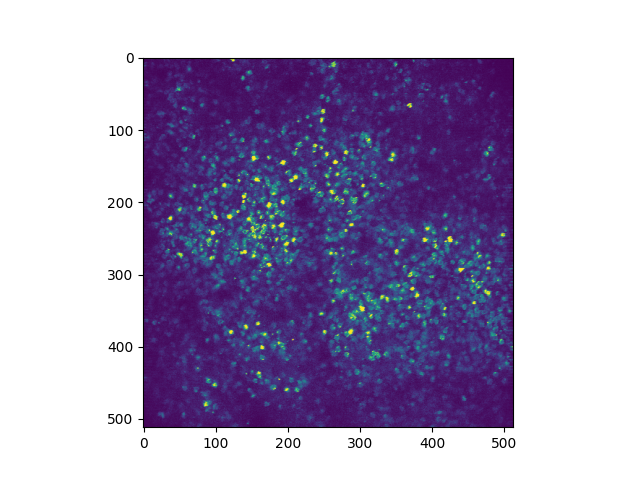

In [5]:
avg_image = imaging.get_average_image()
plt.figure()
plt.imshow(avg_image, vmax=50)

## Interactive Visualization

The library provides interactive widgets for exploring the imaging time series, making it easy to scrub through frames and identify features of interest.

In [6]:
w = pmw.plot_imaging_series(imaging, backend="ipywidgets")

## Preprocessing demo

Preprocessing, like in SpikeInterface, enables one to chain multiple steps in a "lazy" fashion. Here is an example (with some very simple methods)

In [7]:
imaging_med = pmpre.median_filter(imaging, size=3)
imaging_laplace = pmpre.laplace_filter(imaging)
imaging_laplace_med = pmpre.laplace_filter(imaging_laplace)

In [8]:
imaging_dict = {
    "raw": imaging, 
    "med": imaging_med,
    "edge": imaging_laplace,
    # "med+edge": imaging_med_edge
}

In [9]:
pmw.plot_imaging_series(imaging_dict, backend="ipywidgets")

## Cache Data for Processing

To enable efficient processing by downstream tools like Suite2P, we can save the imaging data in a binary format. This creates a cached version optimized for fast access.

In [14]:
imaging_cache = imaging.save(folder="cached_imaging", overwrite=True, n_jobs=1)
# or saved preprocessed!
imaging_pre_cache = imaging_laplace_med.save(folder="cached_pre_imaging", overwrite=True, n_jobs=1)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'cached_imaging\\video_cached_seg0.raw'

## Run Suite2P Extraction

Finally, we run Suite2P's segmentation and extraction pipeline on our cached imaging data. This will identify ROIs (regions of interest) and extract fluorescence traces, which can then be further analyzed using SpikeInterface-style tools.

In [ ]:
suite2p_rois = pms.run_segmentation(imaging=imaging_cache, folder="suite2p_test_run", remove_existing_folder=True)

In [ ]:
# or load it back
suite2p_rois_loaded = pme.read_suite2p_rois("suite2p_test_run/")

In [ ]:
suite2p_rois

In [ ]:
suite2p_cells = suite2p_rois.select_rois(suite2p_rois.roi_ids[suite2p_rois.get_property("iscell")])
suite2p_cells

In [ ]:
w = pmw.plot_rois(suite2p_cells, backend="ipywidgets")

## BONUS: lazy ground-truth simulator for testing

TODO: return ROI object

In [ ]:
imaging_gt = pm.generate_gt_video(durations=[600], mode="gaussian")
imaging_gt_cached = imaging_gt.save(folder="gt", overwrite=True, chunk_duration="1s", n_jobs=16, verbose=True)

In [ ]:
pmw.plot_imaging_series(imaging_gt_cached, backend="ipywidgets")

## Next steps:

- Postprocessing: combine `BaseImaging` + `BaseRois` --> Fluorescence traces, DFF, + more
- More preprocessing
- Modularization of methods